In [1]:
import tensorflow as tf
import numpy as np
import re,os,pathlib,datetime
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [4]:
# Options：best_tiny_model, best_full_model,best_tiny_efficient_model
model_type = 'best_full_model'
model_root = os.path.join(r'yoloModel',model_type)
yolo_model = tf.saved_model.load(model_root)

In [5]:
ocr_model = tf.saved_model.load('rgb_plate_model')

In [6]:
charlist = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[sep]']

In [7]:
provinceslist = ['O', '云', '京', '冀', '吉', '学', '宁', '川', '新', '晋', '桂', '沪', '津', '浙', '渝', '湘', '琼', '甘', '皖', '粤', '苏', '蒙', '藏', '警', '豫', '贵', '赣', '辽', '鄂', '闽', '陕', '青', '鲁', '黑']

In [8]:
len(charlist)

37

In [9]:
CLASS_NAMES= ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

In [10]:
fillColor = (255,0,0)
font = ImageFont.truetype('NotoSansCJK-Black.ttc', 20)

def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        if objectness[i] < 0.5:
            break
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        xmin,ymin=x1y1
        xmax,ymax=x2y2
        plate = np.copy(img[ymin:ymax,xmin:xmax])
        try:
            plate = cv2.cvtColor(plate, cv2.COLOR_BGR2RGB)
        except:
            continue
   
        plate = plate_preprocess(plate)
        plate_num = ocr_model(plate)
        plate_num = decode(plate_num)
        if not plate_num:
            continue
        img = cv2.rectangle(img, x1y1, x2y2, (0, 0, 255), 2)

        img_PIL = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        draw = ImageDraw.Draw(img_PIL)
        draw.text((xmin,ymin-25), plate_num, font=font, fill=fillColor)
        draw.text((xmin,ymax-25), str(objectness[i].numpy()), font=font, fill=fillColor)
        img = cv2.cvtColor(np.asarray(img_PIL),cv2.COLOR_RGB2BGR)
        
    return img

def find_plate(img):
    img = decode_cv2img(img)
    boxes, objectness, classes, nums = yolo_model(tf.expand_dims(img,axis=0))
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        if objectness[0] < 0.5:
            break
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        xmin,ymin=x1y1
        xmax,ymax=x2y2
        print(x1y1,x2y2)
        plate = np.copy(img[ymin:ymax,xmin:xmax]) 

    return plate

def decode_cv2img(img):
  img = tf.image.convert_image_dtype(img,tf.float32)
  img = tf.image.resize(img, [416, 416])
#   img = tf.image.resize(img, [224, 224])
  return img

def draw_fps_on_image(fps, image_np):
    cv2.putText(image_np, fps, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (77, 255, 9), 2)

# @tf.function
def plate_preprocess(img):
    img = tf.image.convert_image_dtype(img,tf.float32)
#     img = tf.image.resize_with_pad(img,60,200)
    img = tf.image.resize(img,[65,225])
    img_list = []
    img_list.append(tf.image.crop_to_bounding_box(
    img, 0, 0, 64, 224
    ))
    img_list = tf.convert_to_tensor(img_list)
    return img_list

def decode(input):
    pred_p,pred_c = input
    num = decode_num(pred_c)
    y, idx, count =  tf.unique_with_counts(tf.argmax(pred_p,axis=-1))
    p = y[tf.argmax(count)]
    p = provinceslist[p]
    plate = p+num
    if len(plate) < 7:
        plate=""
    return plate

def decode_num(input):
    
    batch_size = tf.cast(tf.shape(input)[0], dtype="int32")
    input_length = tf.cast(tf.shape(input)[1], dtype="int32")

    input_length = input_length * tf.ones(shape=(batch_size), dtype="int32")
    decoded,scores = tf.keras.backend.ctc_decode(input,input_length,greedy=True)
#     print(tf.argmax(tf.math.exp(-scores),axis=-1))
    best_scores = tf.math.exp(-scores)[tf.argmax(tf.math.exp(-scores),axis=-1)[0]]
    if best_scores < 0.3:
        return ''
#     print(decoded[0].shape,scores.shape,decoded[0].numpy()[:,0:8])
    plate_list = []
    for i,d in enumerate(decoded[0].numpy()[:,0:8].tolist()):
        plate= []
        for i in d:
            if i == -1:
                break
            plate += charlist[i]
        plate_list.append(''.join(plate))

    plate_scores = {}
    for i,p in enumerate(plate_list):
        plate_scores[p] =[0,0]
    for i,p in enumerate(plate_list):
        s = plate_scores[p][0] + scores[i][0]
        c = plate_scores[p][1] + 1
        plate_scores[p] = [s,c]
    
    for k in plate_scores:
        plate_scores[k] = plate_scores[k][0].numpy() / plate_scores[k][1]
        
#     print(list(plate_scores.values()),list(plate_scores.keys()))
        
        
        
    plate = list(plate_scores.keys())[tf.argmin(list(plate_scores.values()))]
    decoded = decoded[0][tf.argmin(scores)[0]]
    return plate


C:\Users\weiwe\PycharmProjects\tensorflow2.0\github plate\testPlates
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


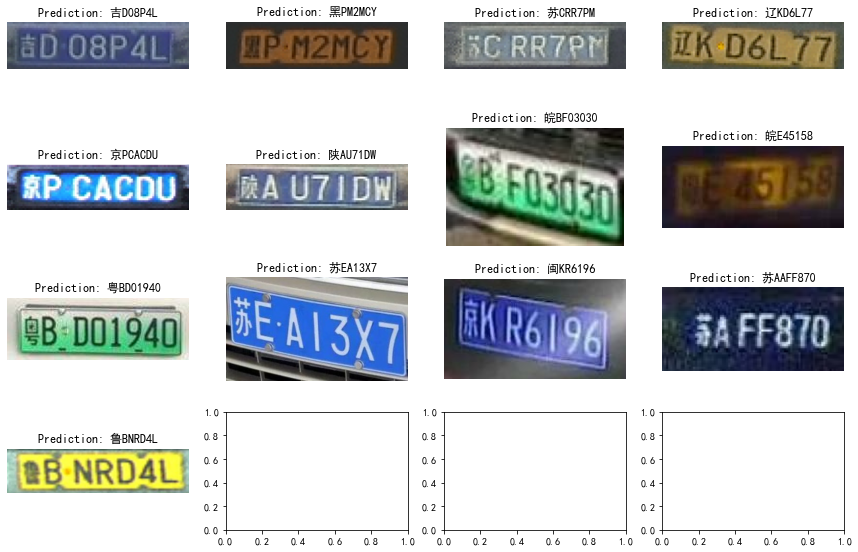

In [11]:
# 直接识别车牌图片
data_root = os.path.join(os.getcwd(),'testPlates')
data_root = pathlib.Path(data_root)
print(data_root)

plt.rcParams['font.sans-serif']=['SimHei']
_, ax = plt.subplots(4, 4, figsize=(15, 10))
for i,file in enumerate(data_root.glob('*')):
    try:
        img = tf.io.read_file(str(file))
        img = tf.image.decode_image(img)
    except:
        continue
    #这种图片不用find plate
    plate = plate_preprocess(img)
    plate_num = decode(ocr_model(plate))
    title = f"Prediction: {plate_num}"
    ax[i // 4, i % 4].imshow(img)
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()

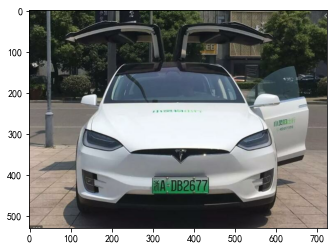

(165, 321) (259, 347)
浙ADB2677 0.003


In [12]:
# 完整车辆图片识别车牌
plate = tf.io.read_file('testCars/新能源车牌.jpg')
plate = tf.image.decode_image(plate)
plt.imshow(plate)
plt.show()
#这种图片要先find plate
plate = find_plate(plate)
plate = plate_preprocess(plate)
start_time = datetime.datetime.now()
plate_num = ocr_model(plate)
elapsed_time = (datetime.datetime.now() - start_time).total_seconds()
print(decode(plate_num),elapsed_time)

In [ ]:
cap = cv2.VideoCapture('video/plate-2.mp4')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 20.0, (720,1080))
# cap = cv2.VideoCapture(0)
cap.isOpened()
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FPS, 29.97)
im_width, im_height = (cap.get(3), cap.get(4))
print(im_width, im_height)

while(cap.isOpened()):
    # Capture frame-by-frame
#     start_time = datetime.datetime.now()
    ret, frame_raw = cap.read()
    frame_raw=cv2.rotate(frame_raw, cv2.ROTATE_90_CLOCKWISE)
    if not ret:
        break
#     frame_raw = cv2.flip(frame_raw, 1)
    # Our operations on the frame come here
    frame = cv2.cvtColor(frame_raw, cv2.COLOR_BGR2RGB)

    # Display the resulting frame
    
#     frame_for_predict = frame
    frame_for_predict = decode_cv2img(frame)
    frame_tensor = tf.expand_dims(frame_for_predict,0)
    
    start_time = datetime.datetime.now()
    with tf.device("GPU:0"):
        boxes, scores, classes, nums = yolo_model(frame_tensor)
    
    
    frame_raw = draw_outputs(frame_raw, (boxes, scores, classes, nums), CLASS_NAMES)
    elapsed_time = (datetime.datetime.now() - start_time).total_seconds()
    
#     elapsed_time = (datetime.datetime.now() - start_time).total_seconds()
    fps = 1 // elapsed_time
    draw_fps_on_image(str(fps),frame_raw)
    out.write(frame_raw)
    cv2.imshow('frame',frame_raw)
#     cv2.waitKey(30)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()

1920.0 1080.0
